## Classificació d'imatges - Xarxes Neuronals i Aprenentatge profund
## Dogs breed classifier


**Biel González Garriga    NIU: 1551813** 

**Sofia Di Capua Martín Mas    NIU: 1603685** 

**Cristina Soler Arenys    NIU: 1603542**

Aquest quadern de Jupyter té com objectiu presentar els resultats obtinguts en el nostre projecte seguint els passos que hem anat completant. Totes les funcions que s'han usat les podreu trobar al github repartides en diferents scripts de python. Per poder entrenar models o provar-los s'haurà d'accedir al fitxer `main.py`. Altrament, per poder executar els scripts l'usuari ha de descarregar les dades de les imatges i guardar-les amb una carpeta, amb nom `Dogs-Breed-class` dins el projecte, d'aquesta maners assegurem un funcionament correcte.

**Índex**   
1. [Descripció de les dades](#id1)
2. [Importar les dades](#id2)
3. [Tractament de les dades](#id3)
4. [Entrenament amb model CNN - no preentrenat](#id4)
5. [Entrenament amb model CNN - preentrenat](#id5)
6. [Diferents formes d'entrenament](#id6)
7. [Aplicació en diferents dades](#id7)
8. [Test dels resultats](#id8)
9. [Evaluació qualitativa i quantitativa](#id9)


### Descripció de les dades<a name="id1"></a>
Se'ns proporciona una base de dades que ens permet fer la classificació de 120 raçes de gossos diferents, a partir d'imatges. Cada imathe té un nom de fitxer que és el seu identificador únic. L'objectiu és ccrear un classificador capaç de reconeixer i determinar la raça d'un gos a partir d'una foto.

In [1]:
import os
import random
import torch

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from PIL import Image as PilImage
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from utils.train import *
from utils.test import *
from utils.utils import model_metrics_plot
from utils.DataLoader import *
from utils.Transformations import *
from utils.menu import *
from utils.FeatureExtraction import *
from models.models import *
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

C:\Users\sofia\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
labels = pd.read_csv('Dog-Breed-classif/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Com podem observar disposem de 10222 imatges de test

In [3]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


Mirem com estaran distribuïdes les imatges segons les raçes per si n'hi ha alguna que predomini per sobre les altres i pogues provocar que l'entrenament s'esbiaixes. Com podem observar a la següent gràfica, la raça de gos amb més imatges és `scottish_deerhound` i el que menys `briard`, però la diferència d'imatges entre aquestes dues no creiem que pugui suposar un problema a l'hora d'entrenar

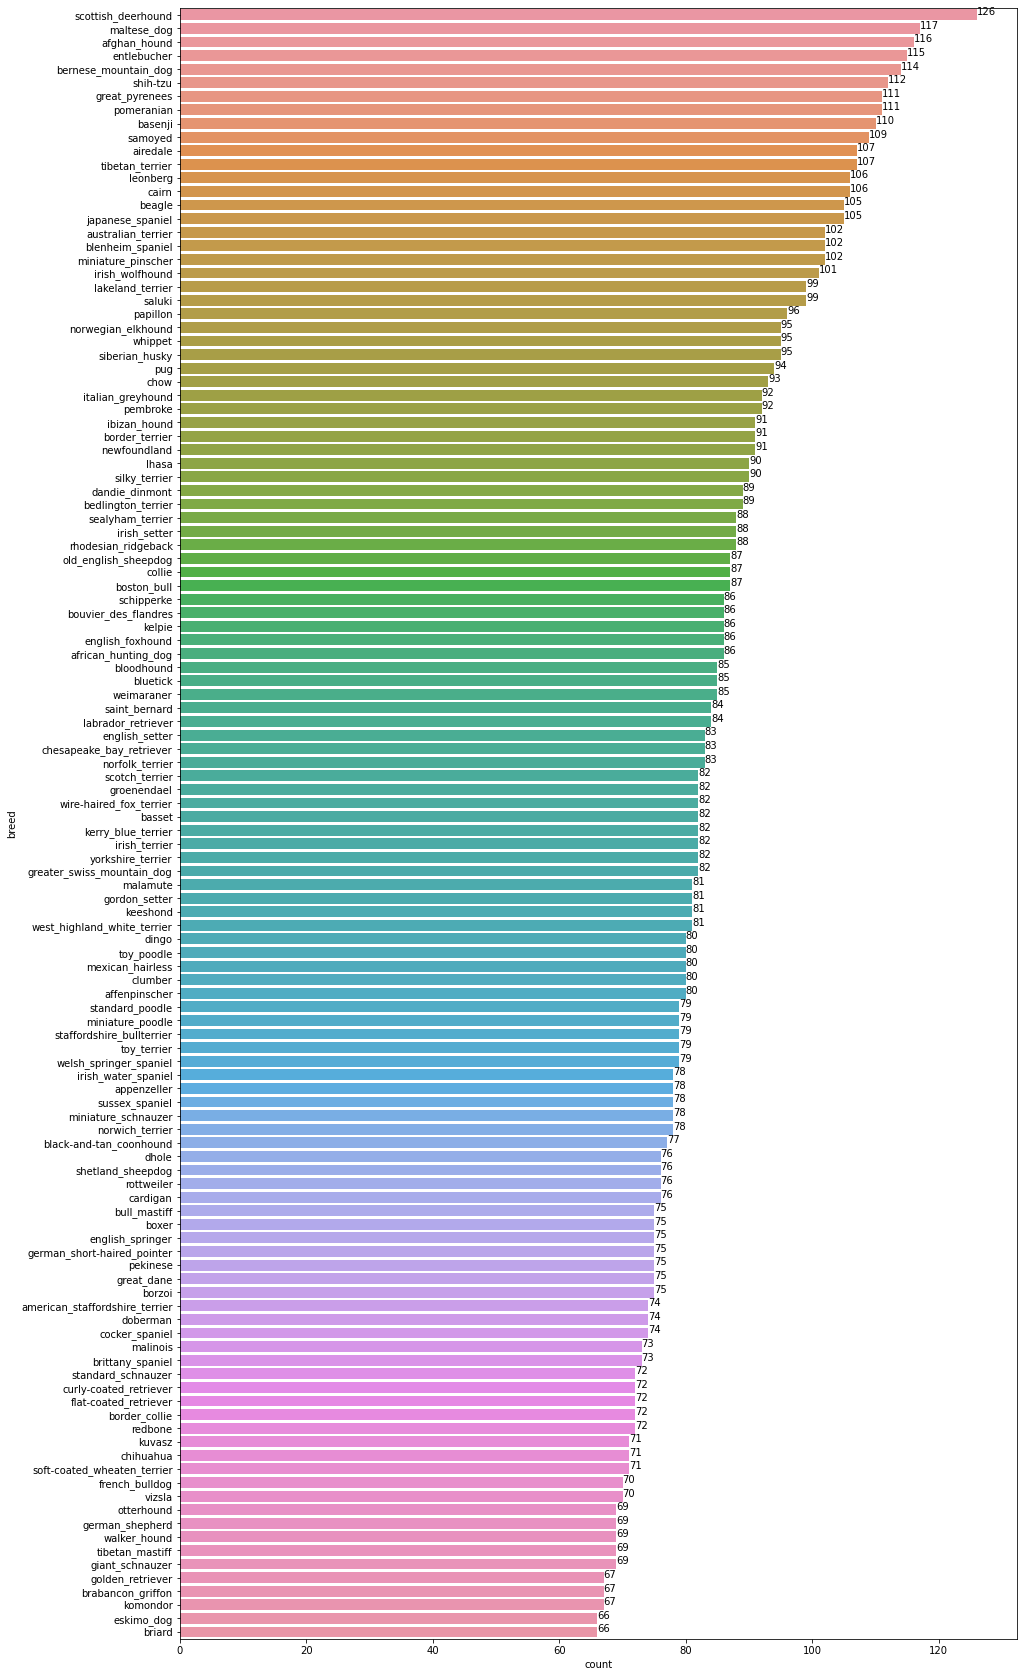

In [4]:
#function to show bar length
def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
#finding top dog brands

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels['breed'],order=labels['breed'].value_counts().index)
barw(ax0)
plt.show()

### Importar les dades<a name="id2"></a>

A la importació de les dades es important tenir descarregat el dataset que se'ns proporciona des de Kaggle i guardat dins una carpeta amb nom `Dogs-Breed-class`.

L'estructura de la carpeta de dades és la següent:
- `\train`: Trobarem les imatges que usarem en el train
- `\test`: Trobarem les imatges per fer proves, no podrem fer una comparació d'accuracy amb aquestes dades ja que no disposem dels valors dels labels reals.
- `labels.csv`: Arxiu csv on trobarem els identificadors de cada imatge amb la raça de gos correponent

Primerament, l'script que s'executarà és el de `FolderClassification.py` (el podeu trobar dins la carpeta de Data). Aquest script, crea carpetes amb noms de les raçes de gos, i ens organitza les imatges de train classificant-les dins la carpeta del nom de raça que li pertoca. Al fer aquest pas, se'ns facilita generar els dataloaders amb la classe propia de pytorch.


Un cop ja tenim les dades preparades, aplicarem el dataloader el que ens permetrà carregar les imatge i per posteriorment utilitzar-les en els nostres models. L'script que s'executarà es troba dins la carpeta Utils (`DataLoaders.py`). En aquest punt les nostres dades provinents de la carpeta de `train`quedan separades en 3 subsets de manera aleatoria. És a dir tindrem el subset: `train`, `val` i `test`, els quals ens permetran fer l'entrenament i mirar quina accuracy aconseguim.

### Tractament de les dades<a name="id3"></a>

El tractament que hem aplicat a les dades com a transformacions per poder entrenar els models són els següents:
- **Transformació 1 (bàsica):** Aquesta transformació és la més bàsica de totes, ja que apliquem les transformacions de resize a la input específicada de 224, centrem la imatge i finalment convertim a tensor i apliquem una normalització a les dades. Aquesta transformació ve donada per la mitjana i la desviació estàndar de les imatges.
- **Transformació 2 (Grey scale):** Tal com indica el nom aquesta transformació converteix en escala de grisos les imatges.
- **Transformació 3 (Complete one):** Podriem dir que és la més completa de totes. A la transformació 1 li afegirem un random flip tan vertical com horitzontal amb probabilitat 0.5, juntament amb un gaussian blur.
- **Transformació 4 (Jitter):** Afegim un jitter a la transformació 1, el que provocarà a la imatge que el color canviï 

In [5]:
from PIL import Image
from torchvision import transforms
img_example=Image.open("./Dog-Breed-classif/test/00a3edd22dc7859c487a64777fc8d093.jpg")
input_size = 224
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

def Show_Image(Image, Picture_Name):
    plt.imshow(Image)
    plt.title(Picture_Name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


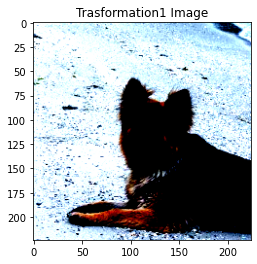

In [6]:
#Transformation 1 (Basic)
T1 = data_transforms_basic["train"](img_example)
Show_Image(T1.permute(1, 2, 0), 'Trasformation1 Image')

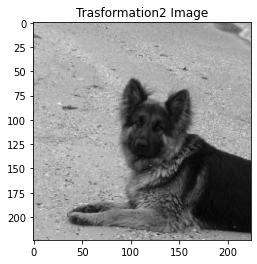

In [7]:
#Transformation 2 (Grey Scale)
T2 = data_transforms_gray_scale["train"](img_example)
Show_Image(T2.permute(1, 2, 0), 'Trasformation2 Image')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


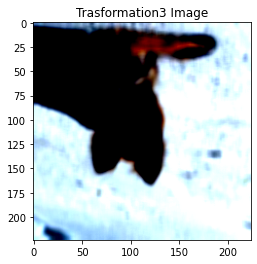

In [8]:
#Transformation 3 (Complete one)
T3 = data_transforms_complete["train"](img_example)
Show_Image(T3.permute(1, 2, 0), 'Trasformation3 Image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


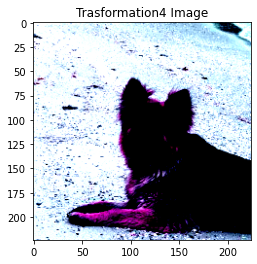

In [9]:
#Transformation 4 (jitter)
T4 = data_transforms_jitter["train"](img_example)
Show_Image(T4.permute(1, 2, 0), 'Trasformation4 Image')

Abans de realitzar entrenaments grossos vam fer petites proves amb les diferents transformacions on va resultar que la que millors resultats ens proporcionava era la transformació 4. Per tant, els entrenaments explicats a continuació han estat fets amb la transformació 4.

### Entrenament amb model CNN - no preentrenat<a name="id4"></a>

Durant les primeres proves vam decidir entrenar el nostre model a partir d'un model fet per nosaltres en scratch. El model que vam provar va ser un CNN bàsic el qual s'ens havia proporcionat alguna entrega setmanal:

In [10]:
class CNN(nn.Module):
    def __init__(self, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size = 5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature, 50)
        self.fc2 = nn.Linear(50, 10)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, self.n_feature)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

Els resultats que vam obtenir van ser catastrófics amb una accuracy de 0.03 com a màxim, és a dir podriem triar aleatoriament la raça del gos i tindriem més probabilitats d'endivinar-la que la xarxa. Vam arribar a la conclusió que aixó passava ja que tot i que disposem de deu mil imatges per realitar l'entrenament, no són suficients perquè la xarxa aprengui les 120 raçes diferents.

Altrament també es va provar de usar la `ResNet50_32x4d` sense preentrenar amb els següent resultat 0.089128305582762. I el `Resnet_18` amb l'optimitzador SGD amb resultat 0.15475024485798236. Com podem veure entrenar les nostres dades amb models no preentrenats no ens donarà bons resultats, així que cambiem l'estrategia a entrenar amb xarxes ja preentrenades.

### Entrenament amb model CNN - preentrenat<a name="id5"></a>

Pytorch dona la opció de fer servir models que ja han estat entrenats, el que fàcilita i ajuda que el model doni millors resultats amb les imatges. Els models seleccionats amb les seves accuracies del test són:

- `Resnet_18`: 
    - Optimitzador Adam: 0.6366307541625857
    - Optimitzador RMSProp: 0.5994123408423114
    - **Optimitzador SGD: 0.7149853085210578**
    
    
- `Resnext101_64x4d`: 
    - **Optimitzador RMSProp: 0.9000979431929481**
 
 
- `Resnext101_32x8d`: 
    - **Optimitzador RMSProp: 0.8707149853085211**
 
 
- `Resnext50_32x4d`: 
    - **Optimitzador SGD: 0.8570029382957884**

Cal tenir en compte que el model més ràpid d'entrenar és el Resnet_18, seria recomenable per persones les quals no disposin d'ordinador potents , ja que, donarà resultats bons com podem veure l'optimitzador SGD i el temps d'entrenament no serà molt alt.

Finalment tenim els models de Resnext101 amb diferent estructura els quals ens proporcionen els millors resultats, però al ser models molt grossos són també els més lents d'entrenar. Per a un millor analisis vem crear una web interactiva (explicada amb més detall en el següent punt), que ens permetia veure l'acuracy de les imatges donades. Realitzant diverses proves, hem vist que el model amb estructura 64x4d en conjunt del test dona una acuraccy més alta, però el model 32x8d reacciona millor a imatges desconegudes individuals donant una score més elevada.




### Web interactiva
D'altra banda, per provar els resultats de la nostre xarxa hem creat un aplicatiu amb streamlit una plataforma d'internet pensada i plantejada per crear aplicacions de python. El que ens permet la nostre pàgina és que l'usuari penji una imatge del que vulgui i la xarxa predirà si es un gos o no, i si ho és ens dirà a quina raça pertany. A més a més ens indicarà quins són els valors amb millor score de la xarxa.

Hem decidit fer l'aplicatiu per poder acostar al usuari el nostre projecte, ja que aquesta seria la part més interactiva.

L'enllaç directe a la pàgina web: https://kermitsc7-dog-breed-dogapp-inaxrc.streamlit.app

### Diferents formes d'entrenament<a name="id6"></a>

Hem realitzat una funció menu que permet provar diferents formes d'entrenament de forma senzilla i clara. Després d'escollir el mode (train, test o both), l'usuari pot escollir el model, si vol que sigui preentrenat o no, si vol fer feature extraction i el tipus d'optimitzador. Aquesta última opció permet canviar l'aprenentatge del model, ja que permet que l'usuari esculli un learning rate i/o momentum i/o un alfa. Descomentant el següent codi ho podeu provar:

### Aplicació en diferents dades<a name="id7"></a>

Per obtenir més dades d'entrenament vam decidir eliminar el fons a les imatges i mirar si la xarxa millorava les prediccions. 

Cal destacar que l'entrenament amb aquestes imatges és nefast amb una accuracy molt i molt baixa per tant no podem tenir en compte les dades per entrenar la xarxa. El que si que succeix és que la xarxa, un cop ja entrenada, respon correctament aquestes imatges ja que únicament visualitza el gos i provoca que la predicció sigui molt més bona.

El codi usat per treure el fons de les imatges es troba en el fitxer BackgroundRemove. Us deixen aquí un codi per treure el fons d'una única imatge:

#### Exemples d'imatges sense fons

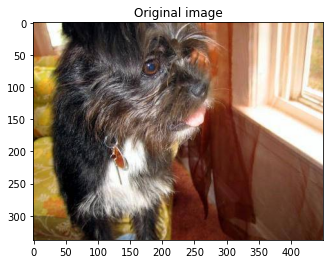

In [11]:
imagesnsfons = Image.open('./Dog-Breed-classif/train/affenpinscher/00ca18751837cd6a22813f8e221f7819.jpg').convert('RGB')
Show_Image(imagesnsfons,  'Original image')

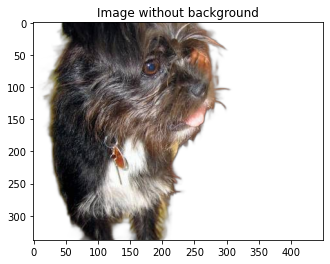

In [12]:
#Remove the background using remgb library
output = remove(imagesnsfons)
Show_Image(output,  'Image without background')

### Test dels resultats<a name="id8"></a>

Provarem els resultats de les diferents xarxes preentrenades amb la mateixa imatge, per visualitzar quins són els resultats que ens donen i quina ens dona millors valors:

In [13]:
def predict(image, model):
    """Return top 5 predictions ranked by highest probability.

    Parameters
    ----------
    :param image: uploaded image
    :type image: jpg
    :rtype: list
    :return: top 5 predictions ranked by highest probability
    """   
    # transform the input image through resizing, normalization
    
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )])

    batch_t = torch.unsqueeze(transform(image), 0)
    #Evaluem en model amb la imatge i mirem els resultats
    model.eval()
    out = model(batch_t)

    with open('datos.txt') as f:
        classes = [line.strip() for line in f.readlines()]
    # return the top 5 predictions ranked by highest probabilities
    prob = torch.nn.functional.softmax(out, dim = 1)[0] * 100
    _, indices = torch.sort(out, descending = True)
    return [(classes[idx], prob[idx].item()) for idx in indices[0][:5]]

In [14]:
model1, _, _ = initialize_model_resnext101_64x4d(120) # El millor model
device = torch.device('cpu')
model1.load_state_dict(torch.load("./models/ResNext101_64x4d_PreTrained.pth", device))

<All keys matched successfully>

In [15]:
model2, _, _ = initialize_model_resnext101_32x8d(120) # El segon millor model
device = torch.device('cpu')
model2.load_state_dict(torch.load("./models/ResNext101_32x8d_PreTrained.pth", device))

<All keys matched successfully>

La imatge que volem predir és la següent, d'on podem intuïr que és un pastor alemany:

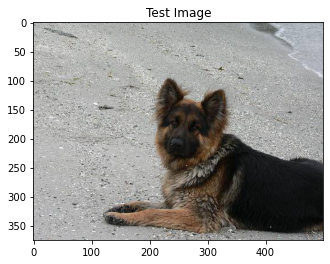

In [16]:
image = Image.open("./Dog-Breed-classif/test/00a3edd22dc7859c487a64777fc8d093.jpg")
Show_Image(image, 'Test Image')

In [17]:
labels = predict(image, model1)
print('resnext_101_64x4d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])
    
labels = predict(image, model2)
print('\nresnext_101_32x8d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])

resnext_101_64x4d
Name: german_shepherd ----> Score: 36.6650276184082
Name: malinois ----> Score: 4.977922439575195
Name: leonberg ----> Score: 3.322767734527588
Name: kelpie ----> Score: 1.5488544702529907
Name: norwegian_elkhound ----> Score: 1.309661626815796

resnext_101_32x8d
Name: german_shepherd ----> Score: 96.69499206542969
Name: airedale ----> Score: 1.4109138250350952
Name: leonberg ----> Score: 0.28958505392074585
Name: tibetan_mastiff ----> Score: 0.1507759541273117
Name: malinois ----> Score: 0.1436917930841446


Com podem observar el model `resnext_101_32x8d` és el que millors resultats ens proporciona, ja que ens dona la puntuació del pastor alemany amb gairebe 100% de score. Per tant, dels dos models amb millor resultats podriem dir que el millor es el de 32x8d. Realitzem diverses proves més amb imatges on el gos no es el primer pla o hi han diversos objectes més que podrien confondre la xarxa.

In [18]:
image2 = Image.open("./Dog-Breed-classif/test/0b69acfc61048e94c7ba772a1f55012b.jpg")
image3 = Image.open("./Dog-Breed-classif/test/0bd08711dd75d82507a002b300f9fc61.jpg")

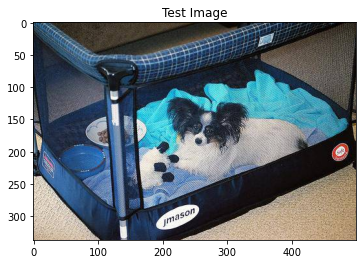

In [19]:
Show_Image(image2, 'Test Image')

In [20]:
labels = predict(image2, model1)
print('resnext_101_64x4d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])
    
labels = predict(image2, model2)
print('\nresnext_101_32x8d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])

resnext_101_64x4d
Name: papillon ----> Score: 71.9741439819336
Name: japanese_spaniel ----> Score: 0.9904072880744934
Name: toy_terrier ----> Score: 0.7378255724906921
Name: pomeranian ----> Score: 0.5376612544059753
Name: great_pyrenees ----> Score: 0.44738245010375977

resnext_101_32x8d
Name: papillon ----> Score: 97.49748229980469
Name: border_collie ----> Score: 0.5557427406311035
Name: collie ----> Score: 0.3281315863132477
Name: toy_terrier ----> Score: 0.2620323896408081
Name: shetland_sheepdog ----> Score: 0.2281239777803421


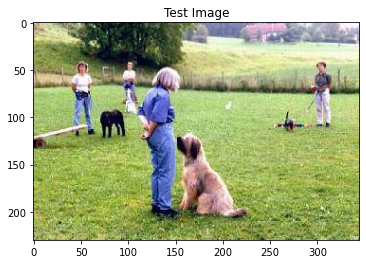

In [21]:
Show_Image(image3, 'Test Image')

In [22]:
labels = predict(image3, model1)
print('resnext_101_64x4d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])
    
labels = predict(image3, model2)
print('\nresnext_101_32x8d')
for i in labels: 
    print("Name:",i[0], "----> Score:", i[1])

resnext_101_64x4d
Name: otterhound ----> Score: 21.465532302856445
Name: leonberg ----> Score: 8.127402305603027
Name: briard ----> Score: 3.9384939670562744
Name: bouvier_des_flandres ----> Score: 3.1292154788970947
Name: afghan_hound ----> Score: 3.098644495010376

resnext_101_32x8d
Name: otterhound ----> Score: 37.172733306884766
Name: silky_terrier ----> Score: 17.180164337158203
Name: english_setter ----> Score: 9.244769096374512
Name: briard ----> Score: 7.422237873077393
Name: bluetick ----> Score: 3.8866236209869385


Com visualitzem a la prova anterior la xarxa reacciona correctament a imatges on el gos pot ser no s'acaba de visualitzar correctament, es troba en un segon pla o hi han humans. També cal destacat que la xarxa prediu el gos predominant de la imatge, és a dir si hi han diversos gossos el que tindrà score més alta serà aquell que es "destaqui" més.

## Evaluació qualitativa i quantitativa<a name="id9"></a>

I per últim però no menys important, l'evaluació dels nostres models. En aquest apartat no evaluarem només com de bé classifican els nostres models sino també com els models han entes les imatges. Per la primera part utilitzarem matrius de confusió, que exposen de manera clara i visual la quantitat de classificacions correctament e incorrectament realitzades. Altrament usarem una feature extraction per veure com llegeix les imatges el model:
#### Matrius de confusió

In [23]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [30]:
### Si s'ha borrat l'output, els insputs eren : 2, 1, y , y , 3, 0.3, 0.5, 0.2
torch.cuda.empty_cache()
batch_size = 12
num_workers = 4
data_path = "./Dog-Breed-classif"
dataloaders = dogs_dataset_dataloders(data_transforms_complete, data_path,
                                          batch_size, num_workers)
accuracy, predictions = menu(dataloaders)

Using:  cpu
#############################
	Dog Breed Classifier
#############################
Please input a mode:
- Only train: 1
- Only test: 2
- Train and Test: 3

2
Select one of the implemented models:
-  ResNext101_32x8d :  1
-  ResNext101_64x4d :  2
-  ResNext50_32x4d :  3
-  Resnet18 :  4
1
Do you want it to be pretrained? [y/n]
y
Do you want to do feature extraction? [y/n]
y
Select one of the implemented optimizers:
-  SGD :  1
-  Adam :  2
-  RMSprop :  3
3
Input a learning rate: 
0.3
Input a momentum: 
0.5
Input an alpha: 
0.2


100%|██████████| 86/86 [06:00<00:00,  4.19s/it]

Test accuracy: 0.8472086190009794


In [31]:
y_true = predictions['label'].astype(np.int64)
y_pred = predictions['prediction'].astype(np.int64)
mtx = (multilabel_confusion_matrix(y_true,y_pred, labels=list(range(1,121)) ) )

In [32]:
confusion_matrix = np.zeros(shape=(120,120))
for true, predict in zip(y_true,y_pred):
    confusion_matrix[predict][true]+=1
print(confusion_matrix)

[[ 7.  0.  0. ...  0.  0.  0.]
 [ 0. 14.  0. ...  0.  0.  0.]
 [ 0.  0.  8. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  9.  0.  0.]
 [ 0.  0.  0. ...  0.  2.  0.]
 [ 0.  0.  0. ...  0.  0.  6.]]


TypeError: 'numpy.ndarray' object is not callable

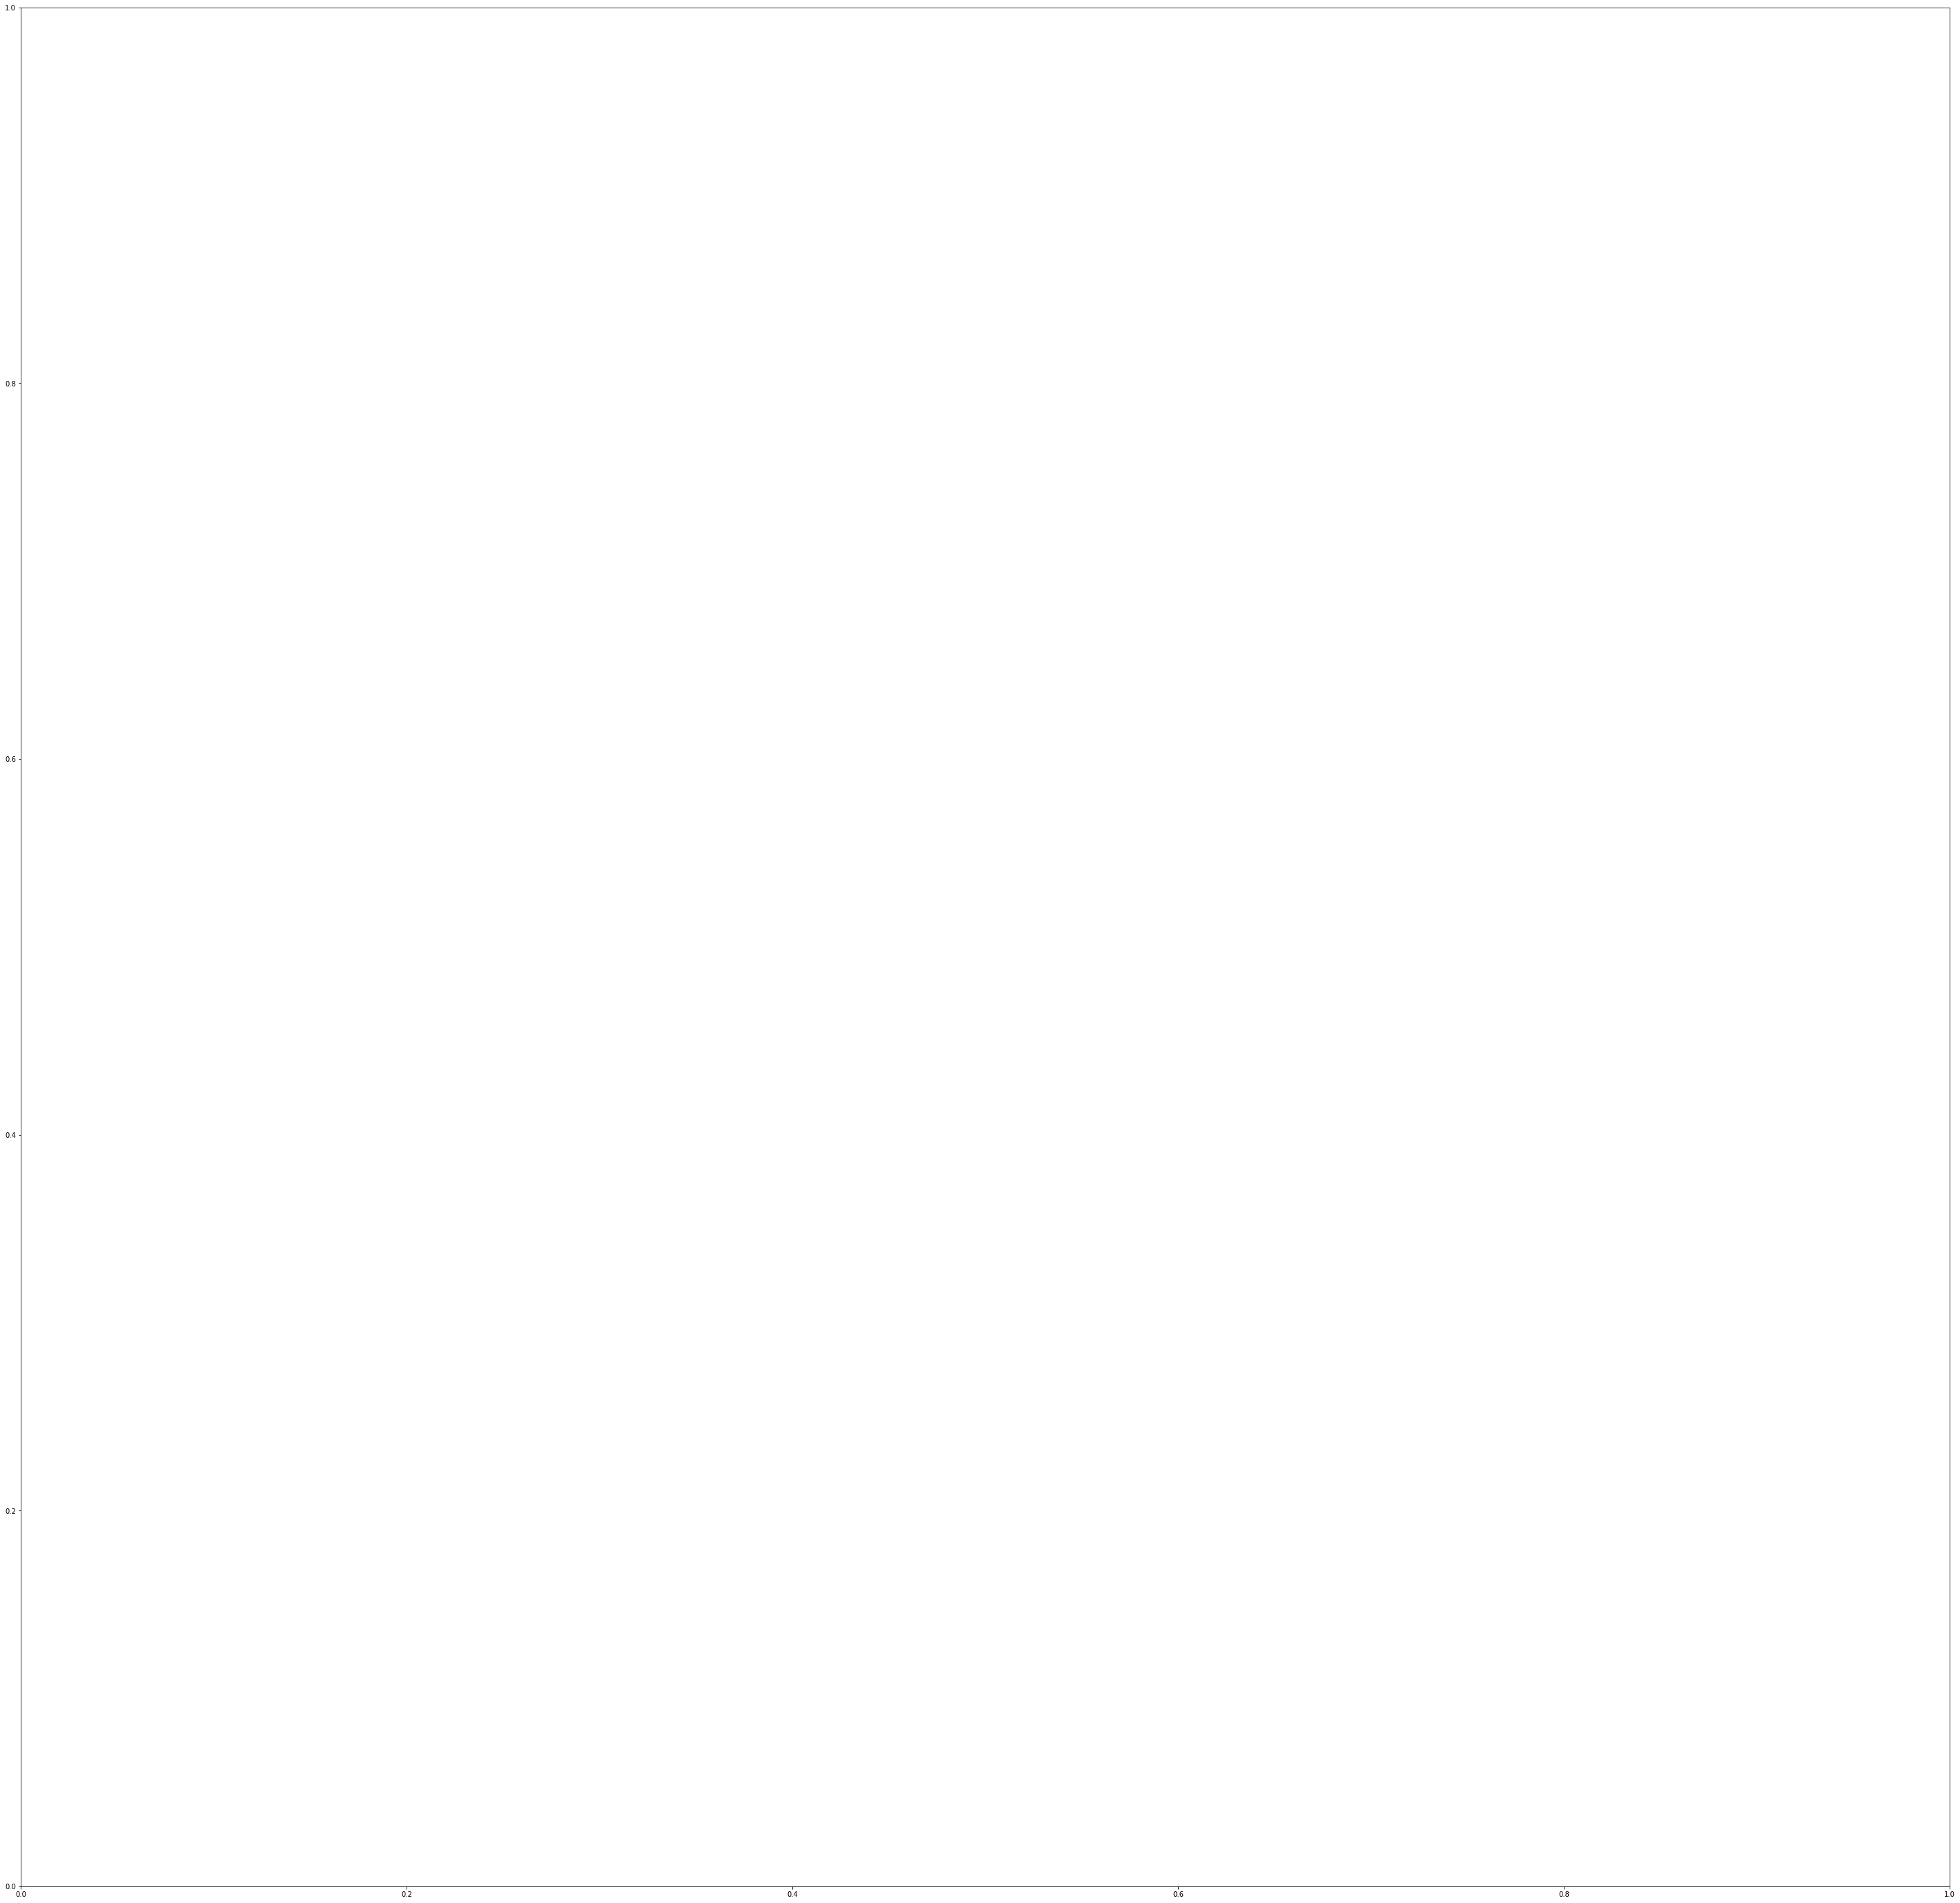

In [34]:
plt.figure(figsize=(50,50))
ax= plt.subplot()
cm = confusion_matrix(y_true, y_pred, labels=list(range(1,121)))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 



## Feature extraction

In [ ]:
plt.imshow(image)
plt.show()
 
data_transforms_jitter = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(input_size),
        transforms.ColorJitter(brightness=.5, hue=.3), # Apply color jitter to the image
        transforms.ToTensor(),
        normalize
    ])

img=np.array(image)
img=data_transforms_jitter(img)
img=img.unsqueeze(0)
print(img.size())

**resnext_101_32x8d**

In [ ]:
feature_extraction(model2,img)

**resnext_101_64x4d**

In [ ]:
feature_extraction(model1,img)

## Heatmap

In [ ]:
from utils.heatmap import *
path1 = "./Dog-Breed-classif/test/00b43aa6064fa6733a391d41fe4c6803.jpg"
path2 = "./Dog-Breed-classif/test/00e71e327e114433191f34054c6bf6f5.jpg"

images = heatmap_32x8(path1)
Image.fromarray(images)

In [ ]:
images = heatmap_32x8(path2)
Image.fromarray(images)